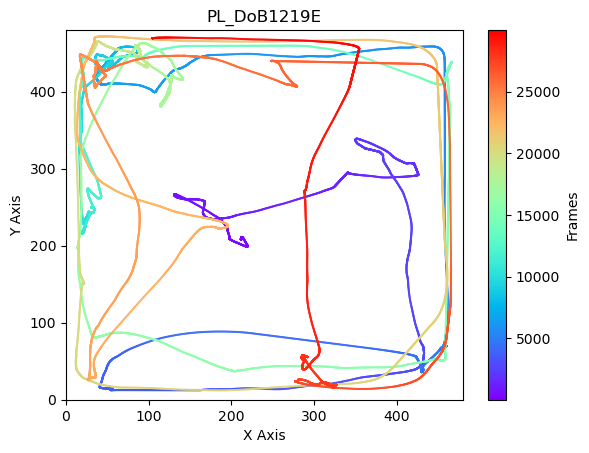

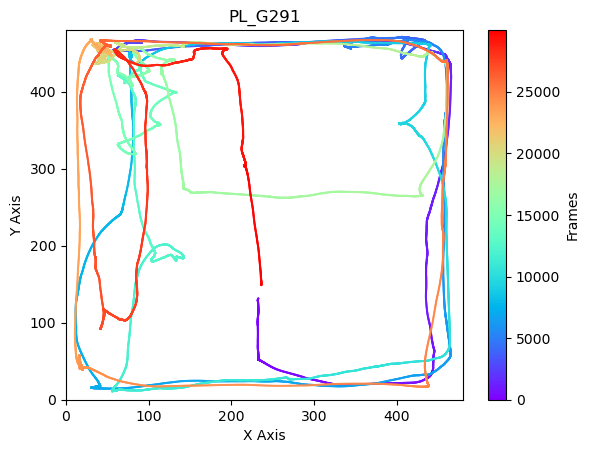

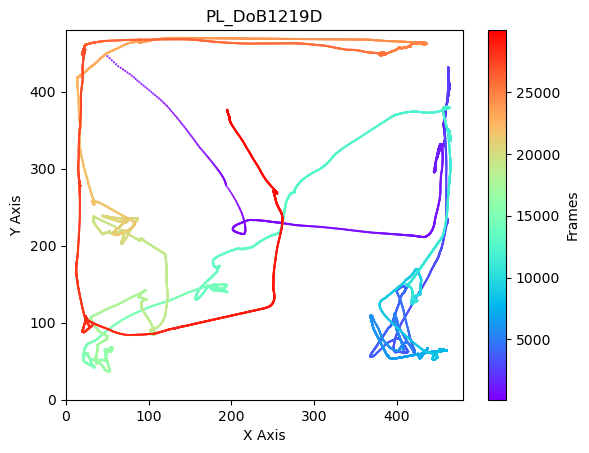

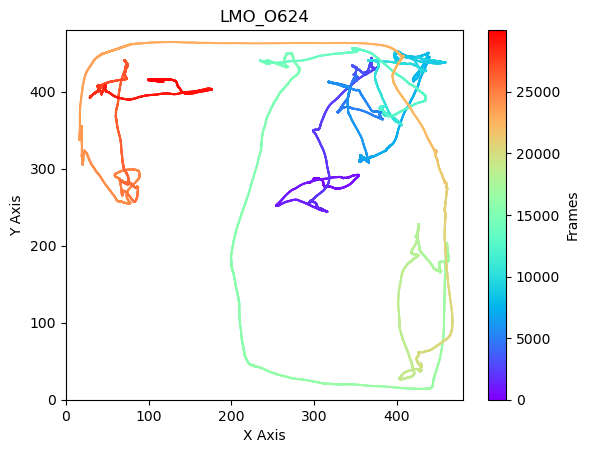

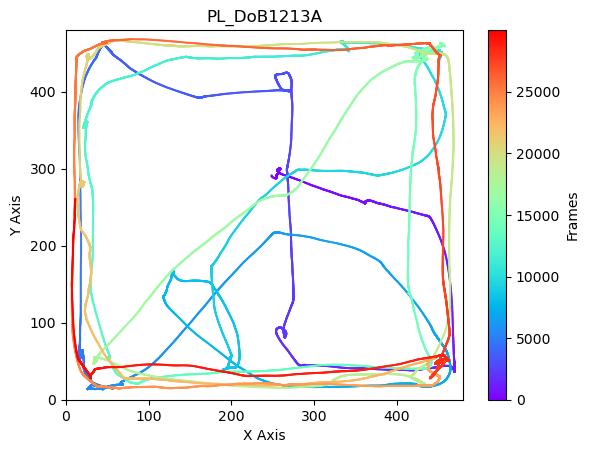

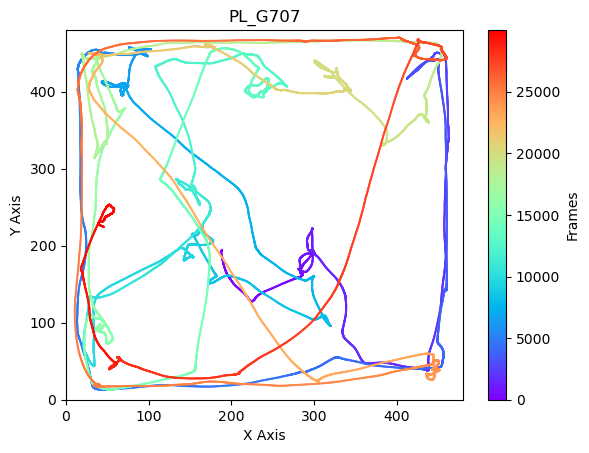

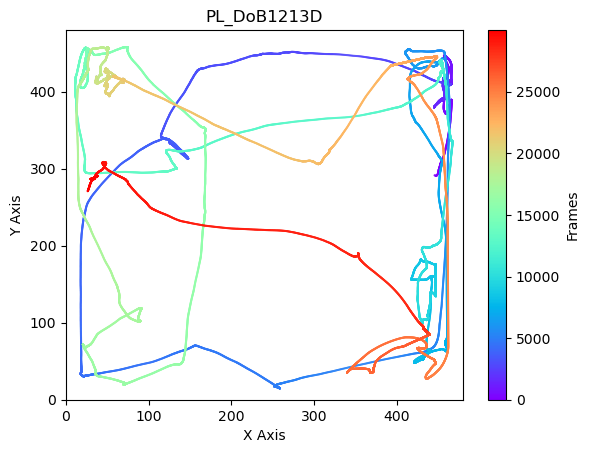

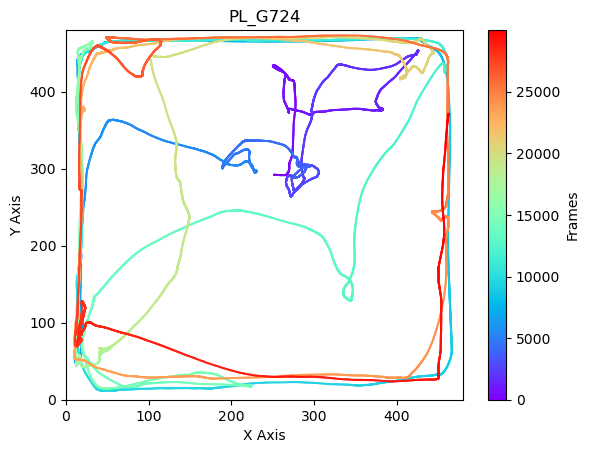

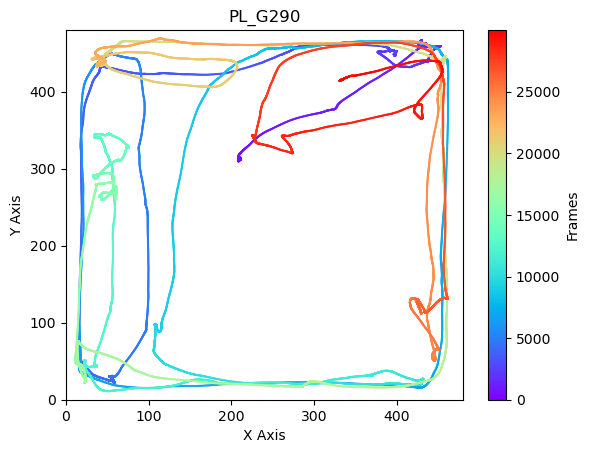

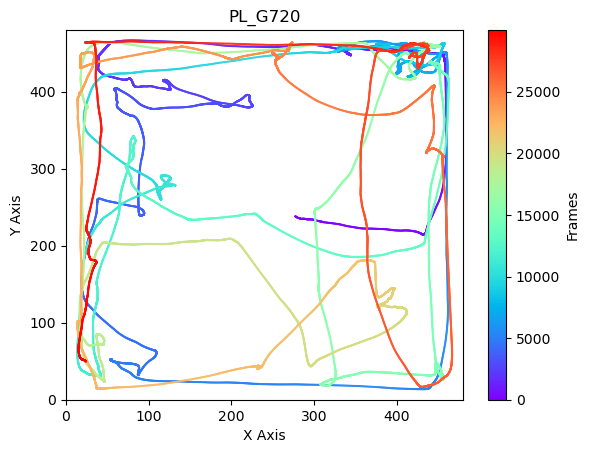

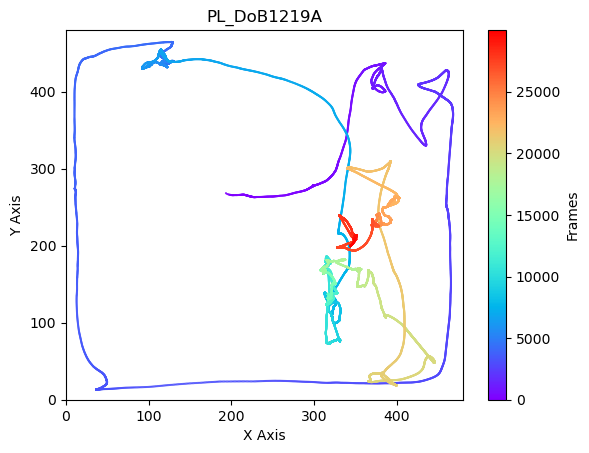

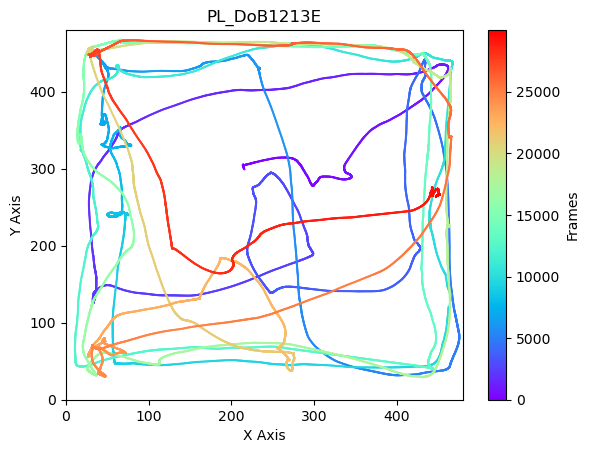

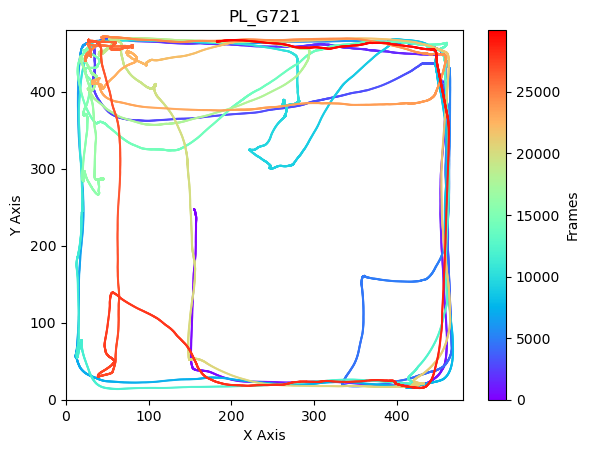

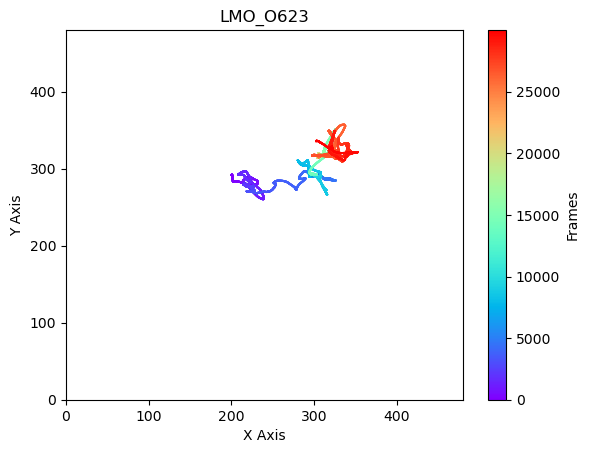

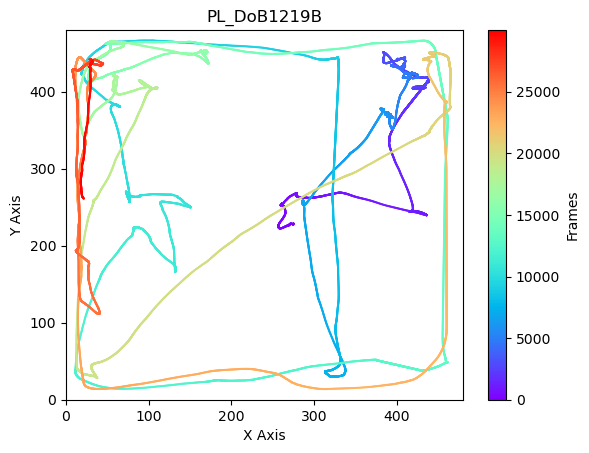

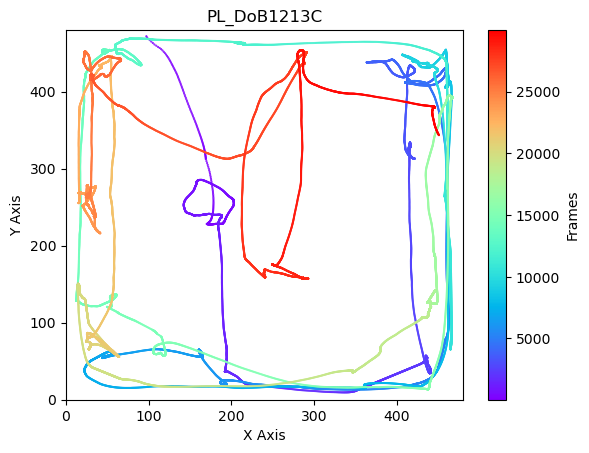

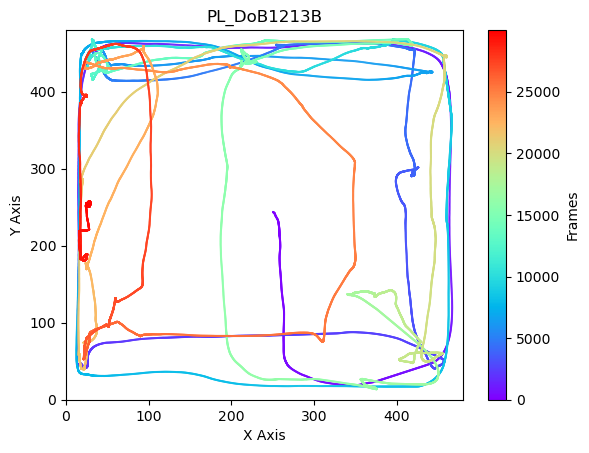

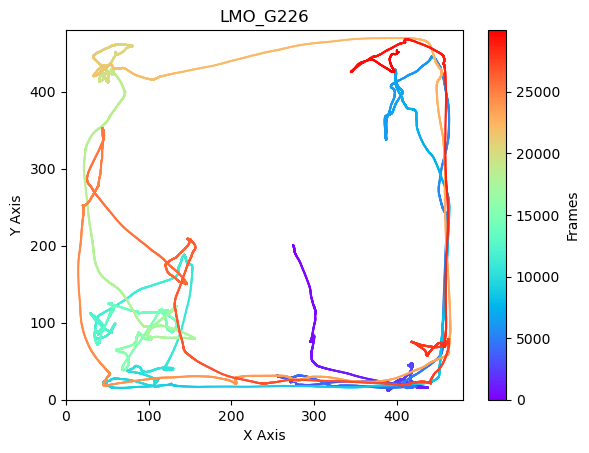

               距離    速度    運動時間
檔名                             
PL_DoB1219E   856  6.78  126.33
PL_G291       836  6.43  130.02
PL_DoB1219D   515  4.48  115.07
LMO_O624      435  3.78  115.04
PL_DoB1213A   907  6.37  142.46
PL_G707       878  5.00  175.56
PL_DoB1213D   612  4.90  124.94
PL_G724       923  6.75  136.82
PL_G290       779  6.54  119.14
PL_G720       982  5.72  171.60
PL_DoB1219A   389  4.35   89.38
PL_DoB1213E   967  5.63  171.70
PL_G721      1099  7.57  145.22
LMO_O623      120  3.38   35.49
PL_DoB1219B   684  5.20  131.47
PL_DoB1213C   829  6.03  137.46
PL_DoB1213B   943  6.89  136.77
LMO_G226      636  4.53  140.37


In [16]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 設定輸出資料夾路徑
output_folder = r"G:\works\Data_archive\8f_behav\grid_walking\2023_07_21\crop\bottom_view"

# 取得所有.h5檔案路徑
file_paths = [os.path.join(output_folder, f) for f in os.listdir(output_folder) if f.endswith('.h5')]

# 儲存所有檔案的距離和速度
results = {}

output_folder = "plots"
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# 迴圈處理每個檔案
for file_path in file_paths:
    # 讀取檔案
    df = pd.read_hdf(file_path)
    
    # 選取所有likelihood欄
    likelihood_cols = [col for col in df.columns if 'likelihood' in col]
    
    # 篩選所有部位中likelihood大於0.6的frame
    mask = (df[likelihood_cols] >= 0.6).all(axis=1)
    df_filtered = df[mask]
    
    # 取出spine1和spine2的座標
    body_central_coords = df_filtered['DLC_resnet50_grid_walkingJul24shuffle1_34000']['body_central'][['x', 'y']]
    
    # 計算中點的座標
    midpoint_coords = body_central_coords

    # 重新分配索引，並根據索引排序
    midpoint_coords = midpoint_coords.reindex(range(df.index.min(), df.index.max()+1))

    # 使用內插法補上空白列的值
    midpoint_coords.interpolate(method='index', inplace=True)

    # 確定時間窗口的大小
    window_size = 100

    # 對x和y這兩列應用rolling方法，使用mean函數計算平均值
    midpoint_coords = midpoint_coords.rolling(window=window_size, min_periods=1).mean()

    # 計算每個時間點的移動距離
    distances = np.sqrt(((midpoint_coords - midpoint_coords.shift()) ** 2).sum(axis=1))
    
    # 計算總移動距離
    total_distance = int(distances.sum() / 480 * 40)
    
    # 計算相鄰frame中點座標的變化量
    coord_diff = np.abs(np.diff(midpoint_coords, axis=0))

    # 找出變化量大於設定 pixel的frame，並計算符合條件的frame數量 (計算moving time)
    num_still_frames = np.sum(np.all(coord_diff >= 0.045, axis=1))
    moving_time = num_still_frames/100

    # 計算平均速度
    avg_speed = round(total_distance / moving_time, 2)
    
    # 儲存結果
    file_name = os.path.basename(file_path)
    prefix = ''
    suffix = '_CTZ_gridwalk_0721_bottomviewDLC_resnet50_grid_walkingJul24shuffle1_34000.h5'
    trimmed_name = file_name[len(prefix):len(file_name)-len(suffix)]
    results[trimmed_name] = {'distance': total_distance, 'speed': avg_speed, 'moving_time' : moving_time}

    x_data = midpoint_coords['x']
    y_data = midpoint_coords['y']

    # 繪製散點圖
    cmap = plt.cm.get_cmap('rainbow')
    plt.scatter(x_data, y_data, c=midpoint_coords.index, cmap=cmap, label='Scatter Plot', marker='.', s=1)

    # 設置x軸和y軸的標籤
    plt.xlabel('X Axis')
    plt.ylabel('Y Axis')

    plt.xlim(0,480)
    plt.ylim(0,480)

    # 設置圖的標題
    plt.title(trimmed_name)

    plt.colorbar(label='Frames')

    # 儲存圖片到plots資料夾中，檔名為scatter_plot.png
    output_file = os.path.join(output_folder, trimmed_name+".png")
    plt.savefig(output_file)


    # 顯示圖形
    plt.show()

    
    
    

# 將結果輸出到 excel 檔案中
df = pd.DataFrame.from_dict(results, orient='index')
df.index.name = '檔名'
df.columns = ['距離', '速度', '運動時間']
df.to_excel('output.xlsx')

# 輸出結果
print(df)